## MNIST with torchvision and skorch

## Example with Pytorch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms 
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
DEVICE

device(type='cpu')

In [4]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

Extracting classifier_data/MNIST/raw/train-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/MNIST/raw
Processing...


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729141890/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [ ]:
import random

fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [5]:
transform = transforms.Compose([
    torchvision.transforms.ToTensor()
])
# Set the train transform
train_dataset.transform = transform
# Set the test transform
test_dataset.transform = transform

In [ ]:
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64,shuffle=True)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self,dropout_rate=0.4,dropout_rate2=0.2,l1=50):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout2d(p=dropout_rate)   

        self.fc1 = nn.Linear(32 * 7 * 7, l1)
        self.drop2=nn.Dropout2d(p=dropout_rate2)

        self.fc2 = nn.Linear(l1, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))

        x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)

        x = x.view(x.size(0),-1)

        x = F.relu(self.fc1(x))
        x = self.drop2(x)

        x = self.fc2(x)

        return x

In [ ]:
model = ConvNet()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion= nn.CrossEntropyLoss()

In [ ]:
valid_loss_min = np.Inf
train_loss_history=[]
val_loss_history=[]
train_acc_history=[]
val_acc_history=[]

num_epochs=10
#dataset_sizes = {'train':len(train_dataset),'val':len(val_dataset),'test':len(test_dataset)}

for epoch in range(num_epochs):
    
    train_loss = 0.0
    train_correct = 0
    
    
    # Training
    model.train()
    for idx, (images, labels) in enumerate(train_loader):
        
        images,labels=images.to(DEVICE),labels.to(DEVICE)
        optimizer.zero_grad() 
        output = model(images).to(DEVICE)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()
    
    valid_loss=0.0
    val_correct = 0
    #Validate Model
    model.eval()
    for idx, (images, labels) in enumerate(valid_loader):
        
        images,labels=images.to(DEVICE),labels.to(DEVICE)
        output = model(images).to(DEVICE)
        loss = criterion(output, labels)
        valid_loss += loss.item()*images.size(0)
        scores, predictions = torch.max(output.data, 1)
        val_correct += (predictions == labels).sum().item()
    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    acc = train_correct/len(train_loader.sampler) * 100
    val_acc = val_correct/len(valid_loader.sampler) * 100
    
    train_loss_history.append(train_loss)
    val_loss_history.append(valid_loss)
    train_acc_history.append(acc)
    val_acc_history.append(val_acc)
    
    print("Epoch:{}/{} \t TL:{:.4f} \t VL:{:.4f} \t TA:{:.2f} %  \t  VA:{:.2f} %".format(epoch+1,num_epochs, 
                                                      train_loss,
                                                      valid_loss,
                                                      acc,
                                                      val_acc))
    
    # Save the best possible model
    if valid_loss < valid_loss_min:
        print("Saving Model")
        torch.save(model.state_dict(), 'MNIST_Weights.pt')
        valid_loss_min = valid_loss

## Skorch

In [6]:
pip install skorch

     |████████████████████████████████| 125 kB 1.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [55]:
import skorch
from skorch import NeuralNetClassifier

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms 

from skorch import NeuralNetClassifier

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
class ConvNet(nn.Module):
    def __init__(self,dropout_rate=0.4,dropout_rate2=0.2,l1=50):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout2d(p=dropout_rate)  
        
        self.fc1 = nn.Linear(32 * 7 * 7, l1)
        self.drop2=nn.Dropout2d(p=dropout_rate2)
        
        self.fc2 = nn.Linear(l1, 10)

    def forward(self, x):
        
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))
        
        x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)
        
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        
        x = self.drop2(x)
        x = self.fc2(x)
        return x

In [11]:
y_train = train_dataset.targets.numpy()

In [47]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ConvNet,
    lr=1e-3,
    batch_size=64,
    optimizer=optim.Adam,
    max_epochs=10,
    criterion=nn.CrossEntropyLoss,
    iterator_train__num_workers=4,
    #iterator_train__shuffle=True,
    iterator_valid__num_workers=4,
    #iterator_valid__shuffle=True,
    device=DEVICE
)

In [48]:
net.fit(train_dataset, y=y_train);

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.3938       0.9687        0.1036  25.1464
      2        0.1315       0.9786        0.0720  24.2807
      3        0.0951       0.9799        0.0656  25.1681
      4        0.0818       0.9856        0.0498  24.4494
      5        0.0703       0.9882        0.0454  25.1731
      6        0.0641       0.9867        0.0451  24.4862
      7        0.0574       0.9894        0.0397  24.6992
      8        0.0515       0.9877        0.0428  25.2326
      9        0.0490       0.9888        0.0388  24.4506
     10        0.0441       0.9897        0.0387  25.1036


In [52]:
net.history[:,'valid_loss']

[0.10364582816511393,
 0.07200700752809644,
 0.06556684777202705,
 0.04978821706554542,
 0.045449351342394945,
 0.045120899214409295,
 0.03966905868239701,
 0.04283358945658741,
 0.038756637408242874,
 0.038652379518840464]

In [53]:
#net.history

[{'batches': [{'train_loss': 2.339961528778076, 'train_batch_size': 64},
   {'train_loss': 2.3424384593963623, 'train_batch_size': 64},
   {'train_loss': 2.3371973037719727, 'train_batch_size': 64},
   {'train_loss': 2.2773642539978027, 'train_batch_size': 64},
   {'train_loss': 2.2512619495391846, 'train_batch_size': 64},
   {'train_loss': 2.2304959297180176, 'train_batch_size': 64},
   {'train_loss': 2.2648723125457764, 'train_batch_size': 64},
   {'train_loss': 2.320169687271118, 'train_batch_size': 64},
   {'train_loss': 2.267254114151001, 'train_batch_size': 64},
   {'train_loss': 2.379284381866455, 'train_batch_size': 64},
   {'train_loss': 2.3210670948028564, 'train_batch_size': 64},
   {'train_loss': 2.227051258087158, 'train_batch_size': 64},
   {'train_loss': 2.269014596939087, 'train_batch_size': 64},
   {'train_loss': 2.242006778717041, 'train_batch_size': 64},
   {'train_loss': 2.2442009449005127, 'train_batch_size': 64},
   {'train_loss': 2.2381021976470947, 'train_batch_

In [15]:
val_acc=[]
val_loss=[]
train_loss=[]
for i in range(10):
    val_acc.append(net.history[i]['valid_acc'])
    val_loss.append(net.history[i]['valid_loss'])
    train_loss.append(net.history[i]['train_loss'])
        
#print('avg val accuracy: {:.4f}'.format(val_acc/10))    

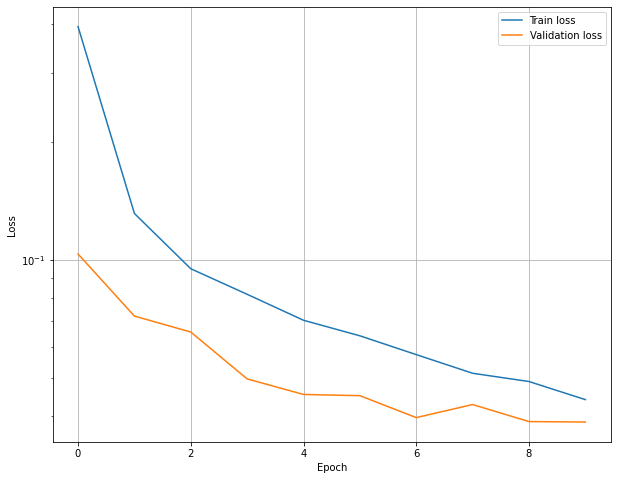

In [16]:
plt.figure(figsize=(10,8))
plt.semilogy(train_loss, label='Train loss')
plt.semilogy(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [57]:
from skorch import scoring

In [59]:
scoring.loss_scoring(net,train_dataset, y=y_train)

0.018448845373111544

## Prediction

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

In [18]:
y_pred = net.predict(test_dataset)
y_test = test_dataset.targets.numpy()

In [24]:
accuracy_score(y_test, y_pred)

0.9909

In [25]:
confusion_matrix(y_test, y_pred)

array([[ 976,    0,    0,    0,    0,    0,    2,    1,    1,    0],
       [   0, 1134,    0,    0,    0,    0,    0,    1,    0,    0],
       [   2,    3, 1022,    1,    0,    0,    0,    3,    1,    0],
       [   0,    0,    3, 1004,    0,    2,    0,    1,    0,    0],
       [   0,    0,    0,    0,  975,    0,    0,    0,    1,    6],
       [   1,    0,    0,    5,    0,  884,    1,    0,    0,    1],
       [   5,    3,    0,    0,    2,    6,  940,    0,    2,    0],
       [   0,    2,    5,    1,    0,    0,    0, 1017,    1,    2],
       [   1,    0,    2,    1,    1,    2,    0,    0,  963,    4],
       [   0,    2,    0,    2,    5,    3,    0,    3,    0,  994]])

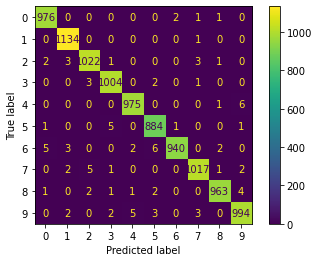

In [26]:
plot_confusion_matrix(net,test_dataset, y_test.reshape(-1, 1))
plt.show()

## K cross validation

In [34]:
from skorch.helper import SliceDataset

train_sliceable = SliceDataset(train_dataset)

In [35]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ConvNet,
    lr=1e-3,
    batch_size=64,
    optimizer=optim.Adam,
    max_epochs=10,
    criterion=nn.CrossEntropyLoss,
    iterator_train__num_workers=4,
    #iterator_train__shuffle=True,
    iterator_valid__num_workers=4,
    #iterator_valid__shuffle=True,
    device=DEVICE
)

In [36]:
scores = cross_val_score(net, train_sliceable,y_train, cv = 5, scoring = "accuracy")

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.4717       0.9621        0.1191  18.9545
      2        0.1441       0.9785        0.0767  20.0966
      3        0.1078       0.9835        0.0556  19.6963
      4        0.0929       0.9851        0.0519  19.4412
      5        0.0777       0.9866        0.0440  20.1908
      6        0.0680       0.9871        0.0437  19.5459
      7        0.0634       0.9885        0.0401  19.6422
      8        0.0586       0.9906        0.0333  20.1109
      9        0.0529       0.9902        0.0357  19.9390
     10        0.0475       0.9907        0.0333  19.7012
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.4641       0.9592        0.1408  20.4813
      2        0.1559       0.9748        0.0894  19.7612
      3        0.1163       0.9761        0.0818  19.7267
      4       

In [60]:
print('validation accuracy for each fold: {}'.format(scores))
print('avg validation accuracy: {:.3f}'.format(scores.mean()))

validation accuracy for each fold: [0.98791667 0.98933333 0.98491667 0.98683333 0.98775   ]
avg validation accuracy: 0.987
